<a href="https://colab.research.google.com/github/Farayi-Myambo/EDSA-Movie-Recommendation-Predict/blob/Farayi_movie/NM2_Recommender_Systems_Draft2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised Learning Predict
© Explore Data Science Academy

## Honour Code
### Team Members
1. Chinonso Agulonu
2. David Mugambi
3. Farayi Myambo
4. Joy Obukohwo
5. Orisemeke ibude
6. Temitope Olaitan

confirm - by submitting this document - that the solutions in this notebook are a result of our own work and that we abide by the EDSA honour code.

Non-compliance with the honour code constitutes a material breach of contract.

### Predict Overview: Recommender System
In today’s technology driven world, recommender systems are socially and economically critical for ensuring that individuals can make appropriate choices surrounding the content they engage with on a daily basis.

Recommender Systems are a type of information filtering system as they improve the quality of search results and provides items that are more relevant to the search item or are related to the search history of the user.

Almost every major tech company has applied recommender systems in some form: Amazon uses it to suggest products to customers, YouTube uses it to decide which video to play next on autoplay and Facebook uses it to recommend pages to like and people to follow. Furthermore, companies like Netflix and Spotify depend on the effectiveness of their recommendation engines for the success of their business

### Problem statement
Construct a recommendation algorithm capable of accurately predicting how a user will rate a movie they have not yet viewed based on their historical preferences


## Table of Contents

<a href=#one>1. Importing Packages</a>

<a href=#two>2. Loading Data</a>

<a href=#three>3. Exploratory Data Analysis (EDA)</a>

<a href=#four>4. Data Engineering</a>

<a href=#five>5. Modeling</a>

<a href=#six>6. Model Performance</a>

<a href=#seven>7. Model Explanations</a>

<a href=#eight>8. Conclusion</a>

<a href=#nine>9. References</a>

 <a id="one"></a>
## 1. Importing Packages
<a href=#cont>Back to Table of Contents</a>

In [1]:
!pip install numpy


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Data manipulation
import numpy as np 
import pandas as pd   
import re
import surprise
# Ignore warnings 
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Data visualization
import matplotlib
import seaborn as sns 
import matplotlib.pyplot as plt 
from wordcloud import WordCloud, STOPWORDS 

# Style
import matplotlib.style as style 
sns.set(font_scale=1.5)
style.use('seaborn-pastel')
sns.set(style="whitegrid")
sns.set_style("dark")

# Building recommender systems
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise import SVD
from surprise import KNNWithMeans
from surprise.model_selection import cross_validate
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

<a id="two"></a>
## 2. Loading the Data
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

In [4]:
movies = pd.read_csv('/content/movies.csv')
imdb_data = pd.read_csv('/content/imdb_data.csv')
tags = pd.read_csv('/content/tags.csv')
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

In [5]:
# Display the first 5 entries in each dataframe 
print('Movies Table')
display(movies.head())
print('ImDB Data')
display(imdb_data.head())
print('Tags')
display(tags.head())
print('Train')
display(train.head())

Movies Table


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


ImDB Data


,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


Tags


,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


Train


,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [6]:
# Count the number of unique entries for features of interest
unique_movies = len(movies['movieId'].unique().tolist())
unique_tags = len(tags['tag'].unique().tolist())
unique_users = len(train['userId'].unique().tolist())
unique_directors = len(imdb_data['director'].unique().tolist())
unique_actors = len(imdb_data['title_cast'].unique().tolist())

# Create a dataframe to store the number of unique entries for features of interest
unique = pd.DataFrame({"movies": [unique_movies],
                       "tags" : [unique_tags],
                       "users": [unique_users],
                       "directors" : [unique_directors],
                       "actors" : [unique_actors]}, index=['unique_entries'])

print('number of unique entries for features of interest')
display(unique.transpose())

number of unique entries for features of interest


,unique_entries
movies,62423
tags,73051
users,162541
directors,11787
actors,17144


In [7]:
# Determine and display the min and max ratings received
min_rating = train.rating.min()
max_rating = train.rating.max()
print('Lowest rating: {}'.format(min_rating))
print('Highest rating: {}'.format(max_rating))

Lowest rating: 0.5
Highest rating: 5.0


#### Observations:

- There are a few tables with more information about the movies, these are all related by the movieId key
- Available information about each movie: Title, cast, runtime, budget, director, genre, plot keywords, tags and ratings
- There are just more than 60000 unique movies and 160000 unique users in the dataset
- There are more unique tags than unique movies in the dataset
- Movies are rated between 0 and 5 with the lowest rating being 0.5 and the highest 5.
- We are also given the timestamp for each rating which isn't particularly useful for our model development since the time rating has nothing to do with a user's preferences or the quality of a film. The timestamps could, however, provide some meaningful insights in our EDA

#### Preparing the data for better visualization
We start by selecting the movie features we want to investigate and create a new dataframe containing these features.

In [8]:
df = imdb_data[['movieId','title_cast','director', 'plot_keywords']]
df = df.merge(movies[['movieId', 'genres', 'title']], on='movieId', how='inner')
df.head()

,movieId,title_cast,director,plot_keywords,genres,title
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,toy|rivalry|cowboy|cgi animation,Adventure|Animation|Children|Comedy|Fantasy,Toy Story (1995)
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,board game|adventurer|fight|game,Adventure|Children|Fantasy,Jumanji (1995)
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,boat|lake|neighbor|rivalry,Comedy|Romance,Grumpier Old Men (1995)
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,black american|husband wife relationship|betra...,Comedy|Drama|Romance,Waiting to Exhale (1995)
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,fatherhood|doberman|dog|mansion,Comedy,Father of the Bride Part II (1995)


In [9]:
# Convert data types to strings for string handling
df['title_cast'] = df.title_cast.astype(str)
df['plot_keywords'] = df.plot_keywords.astype(str)
df['genres'] = df.genres.astype(str)
df['director'] = df.director.astype(str)

# Removing spaces between names
df['director'] = df['director'].apply(lambda x: "".join(x.lower() for x in x.split()))
df['title_cast'] = df['title_cast'].apply(lambda x: "".join(x.lower() for x in x.split()))

# Discarding the pipes between the actors' full names and getting only the first three names
df['title_cast'] = df['title_cast'].map(lambda x: x.split('|')[:3])

# Discarding the pipes between the plot keywords' and getting only the first five words
df['plot_keywords'] = df['plot_keywords'].map(lambda x: x.split('|')[:5])
df['plot_keywords'] = df['plot_keywords'].apply(lambda x: " ".join(x))

# Discarding the pipes between the genres 
df['genres'] = df['genres'].map(lambda x: x.lower().split('|'))
df['genres'] = df['genres'].apply(lambda x: " ".join(x))

df.head()

,movieId,title_cast,director,plot_keywords,genres,title
0,1,"[tomhanks, timallen, donrickles]",johnlasseter,toy rivalry cowboy cgi animation,adventure animation children comedy fantasy,Toy Story (1995)
1,2,"[robinwilliams, jonathanhyde, kirstendunst]",jonathanhensleigh,board game adventurer fight game,adventure children fantasy,Jumanji (1995)
2,3,"[waltermatthau, jacklemmon, sophialoren]",markstevenjohnson,boat lake neighbor rivalry,comedy romance,Grumpier Old Men (1995)
3,4,"[whitneyhouston, angelabassett, lorettadevine]",terrymcmillan,black american husband wife relationship betra...,comedy drama romance,Waiting to Exhale (1995)
4,5,"[stevemartin, dianekeaton, martinshort]",alberthackett,fatherhood doberman dog mansion,comedy,Father of the Bride Part II (1995)


#### MovieLens rating distribution

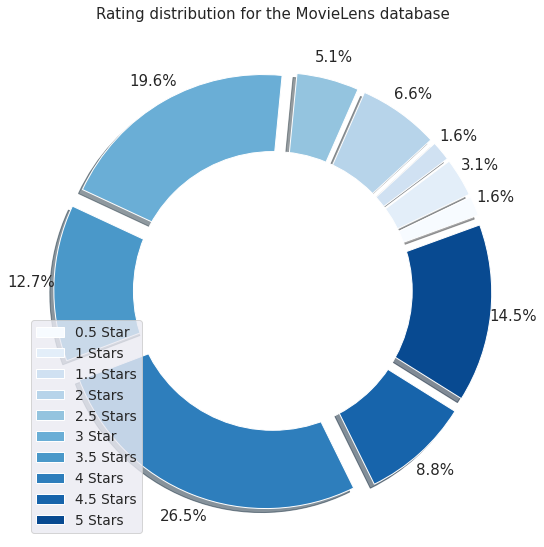

In [10]:
# Merge train with movies to join movie titles and ratings 
ratings = train.merge(movies, on='movieId', how='inner')
ratings.drop('timestamp', axis=1, inplace=True)

# Count how many ratings are in each category (1 star, 2 star, ect)
grouped = pd.DataFrame(ratings.groupby(['rating'])['title'].count())
grouped.rename(columns={'title':'rating_count'}, inplace=True)

# Creating plots 
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(122)
    
# Create colour palette
labels = ['0.5 Star', '1 Stars', '1.5 Stars', '2 Stars', '2.5 Stars', '3 Star', '3.5 Stars', '4 Stars', '4.5 Stars', '5 Stars']
theme = plt.get_cmap('Blues')
ax.set_prop_cycle("color", [theme(1. * i / len(labels))
                                 for i in range(len(labels))])
sns.set(font_scale=1.25)

# Create pie chart
pie = ax.pie(grouped['rating_count'],
                 autopct='%1.1f%%',
                 shadow=True,
                 startangle=20,
                 pctdistance=1.115,
                 explode=(0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1))
   
# Turn pie chart into a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Display donut plot with legend
plt.legend(pie[0], labels, loc="lower left")
ax.set_title('Rating distribution for the MovieLens database\n', fontsize=15)
plt.tight_layout()
plt.show()

#### Distribution of average ratings

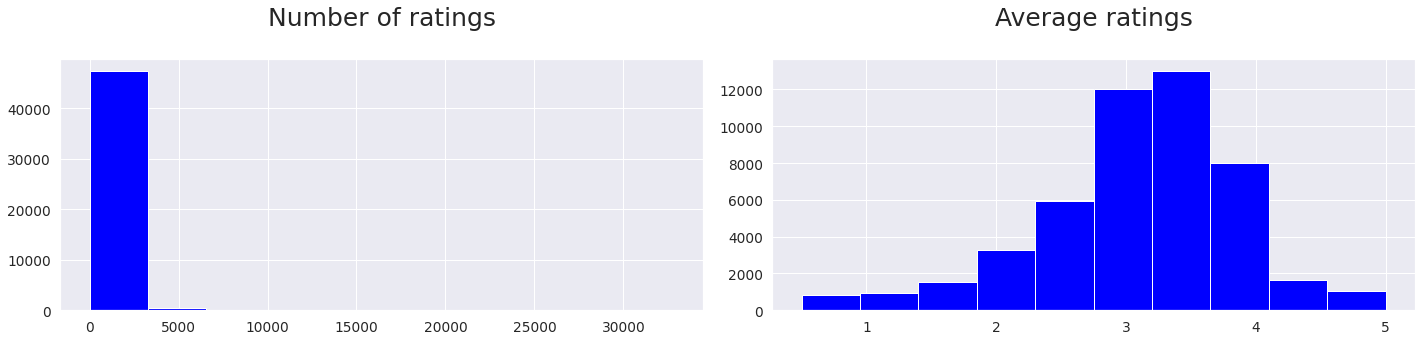

In [11]:
# Determine the average rating and number of ratings for each movie
ratings_mean_count = pd.DataFrame(ratings.groupby(['title'])[['rating']].mean())
ratings_mean_count['rating_counts'] = pd.DataFrame(ratings.groupby(['title'])['rating'].count())
ratings_mean_count['popularity'] = pd.DataFrame(ratings.groupby(['title'])['rating'].count()*ratings.groupby(['title'])['rating'].mean())

# Create a plot of the number of ratings 
f, axarr = plt.subplots(1,2, figsize=(20,5))
axarr[0].hist(ratings_mean_count['rating_counts'], bins=10, color='Blue')
axarr[0].set_title('Number of ratings\n', fontsize=25)

# Create a plot showing the average ratings distribution 
axarr[1].hist(ratings_mean_count['rating'], bins=10, color='Blue')
axarr[1].set_title('Average ratings\n', fontsize=25)

# Display both plots
plt.tight_layout()
plt.show()

##### Release Year of different movies

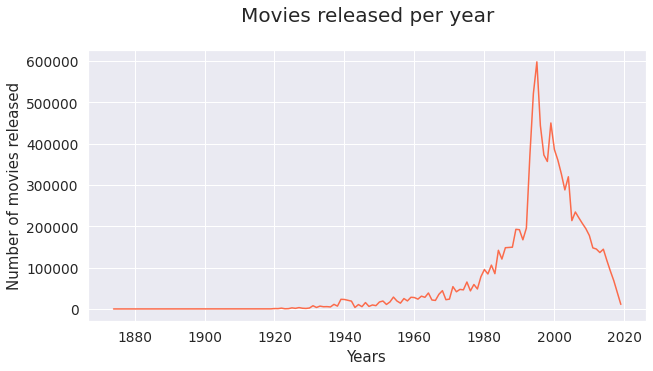

In [12]:
# Extract the release year fron the movie titles
ratings['release_year'] = ratings.title.map(lambda x: re.findall('\d\d\d\d', x))
ratings.release_year = ratings.release_year.apply(lambda x: np.nan if not x else int(x[-1]))
years =  pd.DataFrame(ratings.groupby(['release_year'])['title'].count())
years.rename(columns={'title':'movies released'}, inplace=True)

# Plot the number of movies released per year
plt.figure(figsize=(10,5))
plot = sns.lineplot(data=years, dashes=False, legend=False, palette='Reds_r')

# Add figure labels
plt.xlabel('Years', fontsize=15)
plt.ylabel('Number of movies released', fontsize=15)
plt.title('Movies released per year\n', fontsize=20)

plt.show() 

#### Best Movies

In [13]:
# Extract and display the 10 most popular films in the dataset 
ratings_mean_count = ratings_mean_count.sort_values(by='popularity', ascending=False).head(10)
ratings_mean_count.head(10)

,rating,rating_counts,popularity
title,,,
"Shawshank Redemption, The (1994)",4.417624,32831,145035.0
Pulp Fiction (1994),4.195097,31697,132972.0
Forrest Gump (1994),4.047216,32383,131061.0
"Silence of the Lambs, The (1991)",4.144172,29444,122021.0
"Matrix, The (1999)",4.154253,29014,120531.5
Star Wars: Episode IV - A New Hope (1977),4.111811,27560,113321.5
Schindler's List (1993),4.247625,24004,101960.0
Fight Club (1999),4.227906,23536,99508.0
Star Wars: Episode V - The Empire Strikes Back (1980),4.146236,22956,95181.0


Let's take a closer look at how the ratings for the most popular movie are distributed - Shawshank Redemption

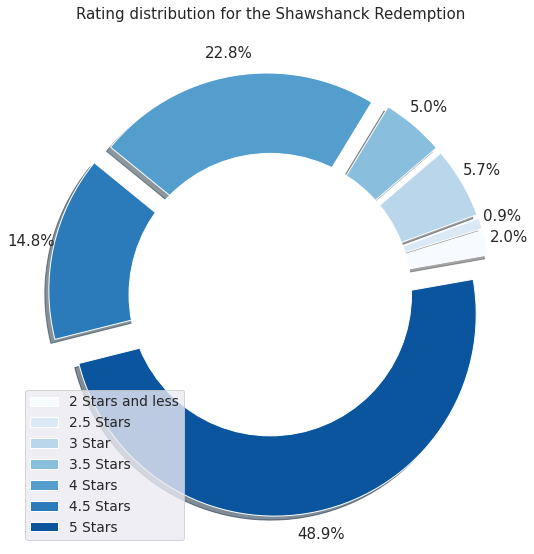

In [14]:
# Extract shawshank redemption ratings
top = ratings[ratings['title']=='Shawshank Redemption, The (1994)']

# Group all 2 star and lower ratings together
top.rating[top.rating == 0.5] = 2 
top.rating[top.rating == 1] = 2 
top.rating[top.rating == 1.5] = 2 

# Count how many ratings are in each category: 1 star, 2 star, ect
grouped = pd.DataFrame(top.groupby(['rating'])['title'].count())
grouped.rename(columns={'title':'rating_count'}, inplace=True)

# Create the figure
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(122)
    
# Create the colour palette
labels = ['2 Stars and less', '2.5 Stars', '3 Star', '3.5 Stars', '4 Stars', '4.5 Stars', '5 Stars']
theme = plt.get_cmap('Blues')
ax.set_prop_cycle("color", [theme(1. * i / len(labels))
                                 for i in range(len(labels))])
sns.set(font_scale=1.25)

# Create the pie chart
pie = ax.pie(grouped['rating_count'],
                 autopct='%1.1f%%',
                 #labels=labels, 
                 shadow=True,
                 startangle=10,
                 pctdistance=1.115,
                 explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1))
   
# Turn the pie chart into a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Display the donut chart with a legend
ax.set_title('Rating distribution for the Shawshanck Redemption\n', fontsize=15)
plt.legend(pie[0], labels, loc="lower left")
plt.tight_layout()
plt.show()

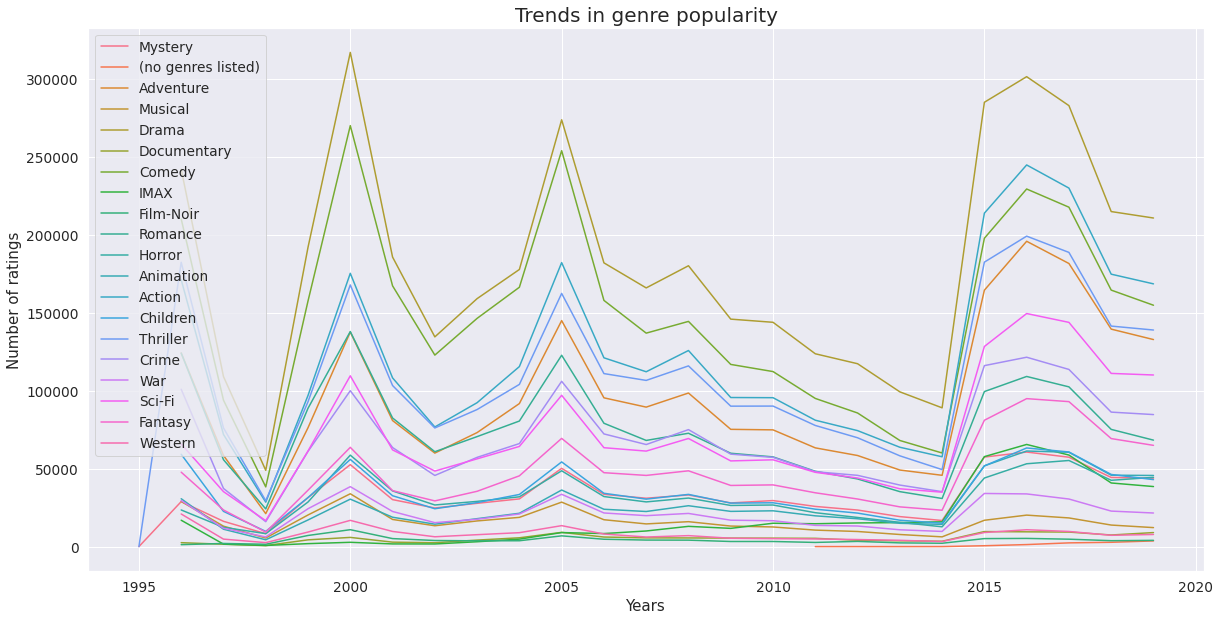

In [15]:
def most_watched(input_df):  
    """"
    This function creates a plot showing the popularity of each genre 
    over the last 50 years.
    
    Input: input_df
           datatype: DataFrame
           
    Output: None
    
    """   
    # Create a copy of the input dataframe and merge it to the movies dataframe
    df = input_df.copy()
    df = df.merge(movies,on='movieId',how='left')
    
    # Create an empty dataframe
    b = pd.DataFrame()
    
    # Extract the timestamps and genres 
    timestamps = [timestamp for timestamp in df.timestamp]
    all_genres = set(','.join([genres.replace('|',',') for genres in df.genres]).split(','))
    
    # Get the number of ratings for each genre for each year since 1970
    for index,genre in enumerate(all_genres):
        a = pd.Series([int((timestamps[i]/31536000)+1970) for i,x in enumerate(df.genres) if genre in x])
        a = a.value_counts()
        b = pd.concat([b,pd.DataFrame({genre:a})],axis=1)
    
    # Plot the trends for each genre on the same line graph 
    plt.figure(figsize=(20,10))
    plot = sns.lineplot(data=b, dashes=False)
      
    # Add plot labels
    plt.title('Trends in genre popularity',fontsize=20)
    plt.xlabel('Years', fontsize=15)
    plt.ylabel('Number of ratings', fontsize=15)
    
    plt.show()
    
    return

most_watched(train)

Lets have a look at the most frequently occuring plot keywords in the movielens dataset

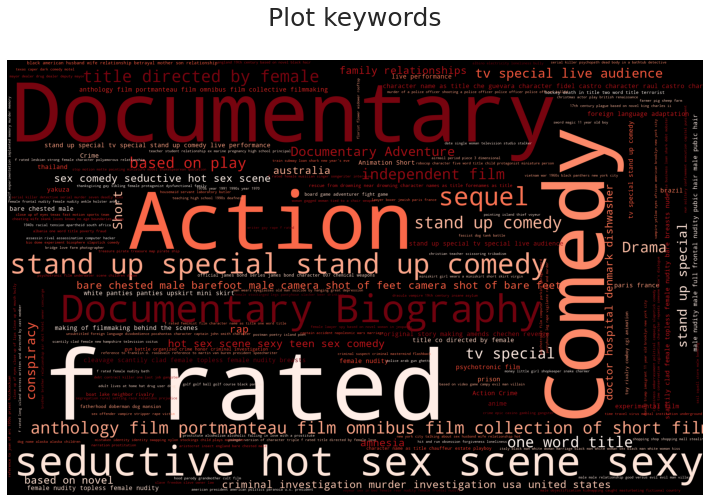

In [16]:
def wordcloud_generator(df, column):  
    """
    This function extracts all the unique keywords in a column
    and counts the number of times each keyword occurs in the column
    while ignoring words that are not meaningful.
    these keywords are then used to generate a word cloud 
    
    Input: df
           datatype: DataFrame
           column
           datatype: str
           
    Output: wordcloud
            Datatype: None
            
    """    
    keyword_counts = {}
    keyword_pair = []
    words = dict()
    
    # list of words that should be ignored
    ignore = ['nan', ' nan', 'nan ', 'seefullsummary', ' seefullsummary', 'seefullsummary ']
    
    # Extract the unique keywords 
    for keyword in [keyword for keyword in df[column] if keyword not in ignore]:
        if keyword in keyword_counts.keys():
            keyword_counts[keyword] += 1
        else:
            keyword_counts[keyword] = 1
     
    # Pair the keywords with their frequencies
    for word,word_freq in keyword_counts.items():
        keyword_pair.append((word,word_freq))
       
    # Sort the keywords accprding to their frequencies
    keyword_pair.sort(key = lambda x: x[1],reverse=True)
    
    # Make it wordcloud-ready
    for s in keyword_pair:
        words[s[0]] = s[1]
        
    # Create a wordcloud using the top 2000 keywords
    wordcloud = WordCloud(width=800, 
                          height=500, 
                          background_color='black', 
                          max_words=2000,
                          max_font_size=110,
                          scale=3,
                          random_state=0,
                          colormap='Reds').generate_from_frequencies(words)

    return wordcloud 

# Plot wordcloud
plot_keywords = wordcloud_generator(df, 'plot_keywords')
f = plt.figure(figsize=(20, 8)) 
plt.imshow(plot_keywords) 
plt.axis('off') 
plt.title('Plot keywords\n', fontsize=25)
plt.show()

Movie directors

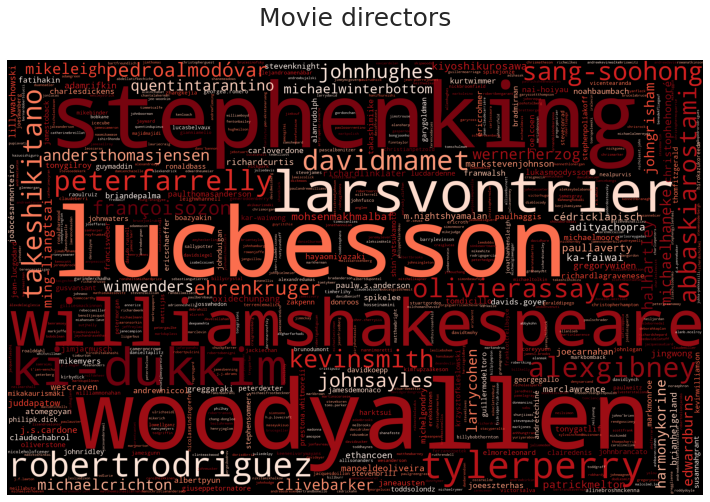

In [17]:
# Generate a WordCloud using the movie directors  
directors = wordcloud_generator(df, 'director')

# Plot the WordCloud 
f = plt.figure(figsize=(20, 8)) 
plt.imshow(directors) 
plt.axis('off') 
plt.title('Movie directors\n', fontsize=25)
plt.show()

Actors

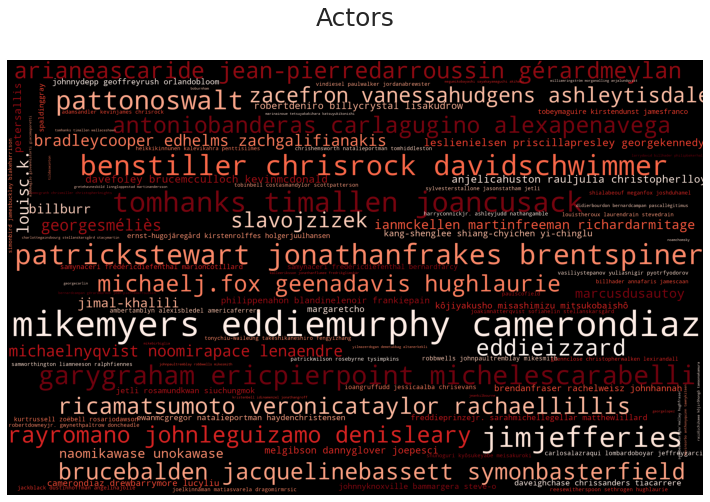

In [18]:
# Generate a wordcloud using the 2000 most frequently occuring actors' names in the dataset
df['title_cast'] = df['title_cast'].apply(lambda x: " ".join(x))
actors = wordcloud_generator(df, 'title_cast')

# plot the WordCloud                        
f = plt.figure(figsize=(20, 8)) 
plt.imshow(actors) 
plt.axis('off') 
plt.title('Actors\n', fontsize=25)
plt.show()

Before we move on to building our recommender system it's good practice (and in this case, very necessary) to free up some memory by deleting the variables/dataframes we're done using

In [19]:
del top
del tags
del grouped
del ratings
del ratings_mean_count

## Content based filtering

We will be using the cast, director, plot keywords and genre as the metadata for our content based recommender system. These columns will be combined to form the corpus for each film which will then be used to determine the similarity between films

In [20]:
# Creating an empty column and list to store the corpus for each movie
df['corpus'] = ''
corpus = []

# List of the columns we want to use to create our corpus 
columns = ['title_cast', 'director', 'plot_keywords', 'genres']

# For each movie, combine the contents of the selected columns to form it's unique corpus 
for i in range(0, len(df['movieId'])):
    words = ''
    for col in columns:
        words = words + df.iloc[i][col] + " "        
    corpus.append(words)

# Add the corpus information for each movie to the dataframe 
df['corpus'] = corpus
df.set_index('movieId', inplace=True)

# Drop the columns we don't need anymore to preserve memory
df.drop(columns=['title_cast', 'director', 'plot_keywords', 'genres'], inplace=True)

df.head()

,title,corpus
movieId,,
1,Toy Story (1995),tomhanks timallen donrickles johnlasseter toy ...
2,Jumanji (1995),robinwilliams jonathanhyde kirstendunst jonath...
3,Grumpier Old Men (1995),waltermatthau jacklemmon sophialoren marksteve...
4,Waiting to Exhale (1995),whitneyhouston angelabassett lorettadevine ter...
5,Father of the Bride Part II (1995),stevemartin dianekeaton martinshort alberthack...


Our corpus will be converted into a bag of words using the count vectorizer

In [21]:
cv = CountVectorizer()
count_matrix = cv.fit_transform(df['corpus'])

Cosine similarity matrix

In [22]:
cos_sim = cosine_similarity(count_matrix, count_matrix)
print(cos_sim.shape)
cos_sim

(24866, 24866)


array([[1.        , 0.20044593, 0.15811388, ..., 0.06681531, 0.        ,
        0.15075567],
       [0.20044593, 1.        , 0.        , ..., 0.14285714, 0.        ,
        0.16116459],
       [0.15811388, 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.06681531, 0.14285714, 0.        , ..., 1.        , 0.        ,
        0.0805823 ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.15075567, 0.16116459, 0.        , ..., 0.0805823 , 0.        ,
        1.        ]])

Top-N Recommendations

In [23]:
def get_topN_recommendations(title, n=10):
    """
    This function gets the top n recomended movies based on the 
    title of the movie input by the user 
    
    Input: title
           Datatype: str
           
           n (default = 10)
           Datatype: int
    """ 
    # Create a a copy of the input dataframe where the index has been reset
    df1 = df.reset_index()
    
    # Extract the movie titles
    titles = df1['title']
    indices = pd.Series(df1.index, index=df['title'])
    idx = indices[title]
    
    # Get the similarity scores of the top n movies most similar to the user input
    sim_scores = list(enumerate(cos_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n]
    
    # Exctract the titles of the top n most similar movies  
    movie_indices = [i[0] for i in sim_scores]
    
    return titles.iloc[movie_indices]

get_topN_recommendations('Ice Age (2002)').head(10)

10648           Ice Age 2: The Meltdown (2006)
18129      Ice Age 4: Continental Drift (2012)
13437    Ice Age: Dawn of the Dinosaurs (2009)
16662                   Winnie the Pooh (2011)
23854     A Flintstones Christmas Carol (1994)
151                      Batman Forever (1995)
9591             Pooh's Heffalump Movie (2005)
4873         Bill & Ted's Bogus Journey (1991)
7038                          Peter Pan (2003)
Name: title, dtype: object

Collaborative Based Filtering

In [24]:
# Creating a small test dataframe to evaluate our models
tests = train.copy()
tests.drop(['timestamp'], axis=1, inplace=True)
tests = tests.head(10000)

# Creating the training data
reader = Reader(rating_scale=(0.5, 5))
test_data = Dataset.load_from_df(tests[['userId','movieId','rating']], reader)

# Compute similarities between users using cosine distance
sim_options = {"name": "cosine",
               "user_based": True}  

# Evaluate the model 
user = KNNWithMeans(sim_options=sim_options)
cv = cross_validate(user, test_data, cv=5, measures=['RMSE'], verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1179  1.1181  1.1082  1.1041  1.1000  1.1097  0.0073  
Fit time          1.49    1.04    0.83    1.05    0.85    1.05    0.24    
Test time         0.02    0.02    0.02    0.02    0.02    0.02    0.00    


Item-item collaborative based filtering

In [ ]:
# Compute similarities between items using cosine distance
sim_options = {"name": "cosine",
               "user_based": False}  

# Fit the KNNwithmeans algorithm to the training set
item_based = KNNWithMeans(sim_options=sim_options)

# Evaluate the model 
cv = cross_validate(item_based, test_data, cv=5, measures=['RMSE'], verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...


Singular value decomposition (SVD)

In [ ]:
# Evaluate the model 
svd = SVD(random_state=0)
cv = cross_validate(svd, test_data, cv=5, measures=['RMSE'], verbose=True)

In [ ]:
# Train the model on the entire dataset 
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(train[['userId','movieId','rating']], reader)
trainingSet = data.build_full_trainset()
svd.fit(trainingSet)

# Make predictions using the trained model
pred = [svd.predict(test.userId[i],test.movieId[i]).est for i in test.index]
test['rating'] = pred

In [ ]:
# Create the csv file for submission
test['Id'] = test['userId'].astype(int)+'_'+test['movieId'].astype(int)
test = test[['Id','rating']]
test.to_csv('svd_submission3.csv', index=False)